In [116]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import norm
from io_utils import load_models, load_matrices_from_dir

In [118]:
# matrix = "bcsstk18"
matrix = "cbuckle"
df = pd.read_csv(f"data/{matrix}_1000_testing.csv")
errorfree_iterations = df["errorfree_iterations"][0]  # all the same
n_rows = df["n_rows"][0]  # all the same
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,cbuckle.mat,341,0.000001,34100,12766,133,798,9.993116e-07,True,0.553754,373.369101,13681,2.340176
1,cbuckle.mat,341,0.000001,34100,9685,293,358,9.810659e-07,True,0.253908,485.237722,13681,1.049853
2,cbuckle.mat,341,0.000001,34100,2906,80,355,9.727220e-07,True,0.277555,99.923192,13681,1.041056
3,cbuckle.mat,341,0.000001,34100,10030,45,384,9.812118e-07,True,0.272684,373.369101,13681,1.126100
4,cbuckle.mat,341,0.000001,34100,9582,310,7608,9.999793e-07,True,5.194308,38410.569328,13681,22.310850


In [119]:
# chosen_model = "./models/bcsstk18/best_RandomForestRegressor_2024_01_09-02_19_47_PM.pkl"
chosen_model = "./models/cbuckle/best_KNeighborsRegressor_2024_01_09-02_10_49_PM.pkl"
model = load_models([chosen_model])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_neighbors=10, p=1.8733986290581737))])

In [120]:
X = df[["error_iter", "pos_2norm"]].to_numpy()
df["prot_score"] = model.predict(X)
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown,prot_score
0,cbuckle.mat,341,0.000001,34100,12766,133,798,9.993116e-07,True,0.553754,373.369101,13681,2.340176,2.194135
1,cbuckle.mat,341,0.000001,34100,9685,293,358,9.810659e-07,True,0.253908,485.237722,13681,1.049853,1.187390
2,cbuckle.mat,341,0.000001,34100,2906,80,355,9.727220e-07,True,0.277555,99.923192,13681,1.041056,1.040762
3,cbuckle.mat,341,0.000001,34100,10030,45,384,9.812118e-07,True,0.272684,373.369101,13681,1.126100,1.138416
4,cbuckle.mat,341,0.000001,34100,9582,310,7608,9.999793e-07,True,5.194308,38410.569328,13681,22.310850,28.476540


In [121]:
# plt.plot(ps, mean_prot_slowdowns, label=f"Smart Protection", c="green")
# plt.plot(ps, [mean_nonprot_slowdown] * len(ps),
#          label=f"No Protection ({round(mean_nonprot_slowdown, 2)})", c="red")
# plt.plot(ps, [1] * len(ps), label="Full Protection (1)", c="black")
# plt.xlabel("$p$")
# plt.ylabel("Mean Slowdown")
# plt.title("Mean Slowdown ($I_e / I_o$) Over 1000 Runs, Varying $p$ ")
# plt.legend()
# plt.grid()
# plt.savefig(f"./figures/{matrix}/mean_slowdowns.png")
# plt.show()

In [122]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<13681x13681 sparse matrix of type '<class 'numpy.float64'>'
	with 676515 stored elements in Compressed Sparse Column format>

In [123]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                            for i in range(errorfree_iterations)])
df_preds = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df_preds["output"] = model.predict(df_preds[["i", "2norm"]].to_numpy())
df_preds_piv = df_preds.pivot(index=["2norm", "rowid"], columns="i", values="output")
prot_scores = df_preds_piv.to_numpy().T
df_preds_piv.head()

i                    0.0       1.0       2.0       3.0      4.0       5.0    \
2norm    rowid                                                                
3.566815 6841.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         1.0      1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         10262.0  1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         3422.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
3.571172 6949.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   

i                    6.0       7.0      8.0       9.0    ...     331.0  \
2norm    rowid                                           ...             
3.566815 6841.0   1.203226  1.212903  1.24956  1.250147  ...  0.984164   
         1.0      1.203226  1.212903  1.24956  1.250147  ...  0.984164   
         10262.0  1.203226  1.212903  1.24956  1.250147  ...  0.984164   
         3422.0   1.203226  1.212903  1.24956  1.250147  ...  0.984164   
3.571172 6949.0   1.203226  1.212903  1.24956  1.250147  ...  0.984164   

i                    332.0     333.0     334.0     335.0     336.0     337.0  \
2norm    rowid                                                                 
3.566815 6841.0   0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   
         1.0      0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   
         10262.0  0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   
         3422.0   0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   
3.571172 6949.0   0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   

i                    338.0     339.0     340.0  
2norm    rowid                                  
3.566815 6841.0   0.995308  0.995308  0.995308  
         1.0      0.995308  0.995308  0.995308  
         10262.0  0.995308  0.995308  0.995308  
         3422.0   0.995308  0.995308  0.995308  
3.571172 6949.0   0.995308  0.995308  0.995308  

[5 rows x 341 columns]

In [124]:
ps = list(np.arange(1 / 98, 1.01, 0.01))
percentages = np.arange(0.01, 1.0, 0.01)
nonerror_runs_by_p = {p: int((len(df) / p) - len(df)) for p in ps}
max_nonerror_runs = int((len(df) / min(ps)) - len(df))
solve_iterations = np.append(df["solve_iterations"], [errorfree_iterations] * max_nonerror_runs)
slowdowns = np.append(df["slowdown"], [1] * max_nonerror_runs)
errorfree_op_count = errorfree_iterations * n_rows

In [125]:
def compute_overheads(error_iterations, n_protections):
    return ((error_iterations * n_rows + n_protections) - errorfree_op_count) / errorfree_op_count

def protect(error_iterations, protections):
    return np.vectorize(lambda i: error_iterations[i] if not protections[i]
                        else errorfree_iterations)(range(len(error_iterations)))

def make_p_overhead_dataframe(ohs_by_p):
    return pd.concat([pd.DataFrame({"p": [ps[i]] * len(os), "overhead": os})
                         for i, os in enumerate(ohs_by_p)], ignore_index=True)

In [126]:
nonprot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    nonprot_overheads = compute_overheads(solve_iterations[:data_size], 0)
    nonprot_overheads_by_p.append(nonprot_overheads)

nonprot_df = make_p_overhead_dataframe(nonprot_overheads_by_p)

In [127]:
prot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    # for the purpose of choosing solve_iterations or errorfree_iterations, did_protect will
    # always be False for nonerror runs, but this is fine because n_protections is computed
    # later for the purposes of calculating overhead
    protections = np.append(df["prot_score"] > (1 + (1 / p)), [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = (prot_scores > (1 + (1 / p))).sum()

    prot_overheads = compute_overheads(prot_iterations, n_protections)
    prot_overheads_by_p.append(prot_overheads)

prot_df = make_p_overhead_dataframe(prot_overheads_by_p)

In [128]:
random_overheads = []
for perc in percentages:
    protections = np.random.rand(len(df)) < perc
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = int(errorfree_iterations * n_rows * perc)
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    random_overheads.append(prot_overheads.mean())
    
best_random_percentage = percentages[np.argmin(random_overheads)]
rand_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    protections = np.random.rand(data_size) < best_random_percentage

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = int(errorfree_iterations * n_rows * perc)
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    rand_overheads_by_p.append(prot_overheads)

rand_df = make_p_overhead_dataframe(rand_overheads_by_p)

In [129]:
r2ns = np.array(list(pos_2norms.values()))
r2n_overheads = []
for perc in percentages:
    cutoff = np.quantile(r2ns, 1 - perc)
    protections = df["pos_2norm"] >= cutoff
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads.append(prot_overheads.mean())

best_r2n_percentage = percentages[np.argmin(r2n_overheads)]
cutoff = np.quantile(r2ns, 1 - best_r2n_percentage)
r2n_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    protections = np.append(df["pos_2norm"] >= cutoff, [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads_by_p.append(prot_overheads)

r2n_df = make_p_overhead_dataframe(r2n_overheads_by_p)

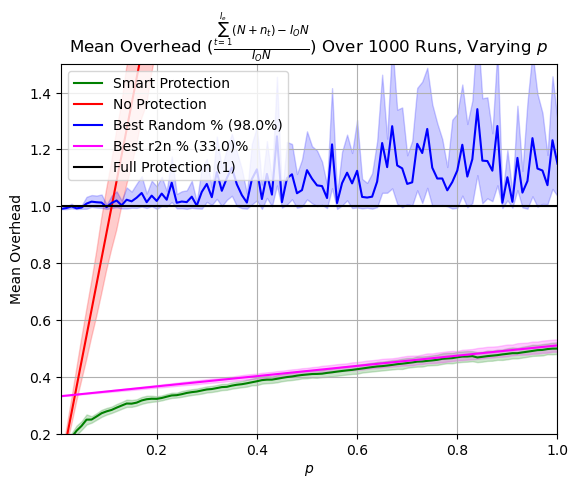

In [130]:
sns.lineplot(prot_df, x="p", y="overhead",
         label="Smart Protection", c="green")
sns.lineplot(nonprot_df, x="p", y="overhead",
             label="No Protection", c="red")
sns.lineplot(rand_df, x="p", y="overhead",
             label=f"Best Random % ({best_random_percentage * 100}%)", c="blue")
sns.lineplot(r2n_df, x="p", y="overhead",
             label=f"Best r2n % ({best_r2n_percentage * 100})%", c="magenta")
plt.plot(ps, [1] * len(ps), label="Full Protection (1)", c="black")

plt.xlabel("$p$")
plt.ylabel("Mean Overhead")
overhead_formula = r"$ \frac{\sum_{t=1}^{I_e}(N + n_t) - I_ON}{I_ON} $"
plt.title(f"Mean Overhead ({overhead_formula}) Over 1000 Runs, Varying $p$ ")
plt.legend()
plt.grid()
plt.xlim(0.01, 1)
plt.ylim(0.2, 1.5)
plt.savefig(f"./figures/{matrix}/mean_overheads.png")
plt.show()

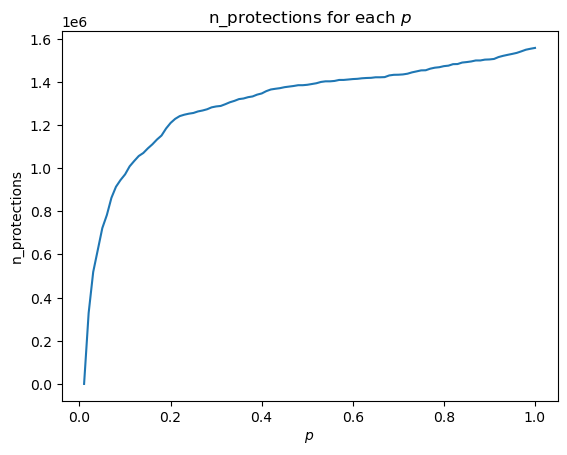

In [131]:
n_prots_per_p = []

for p in ps:
    protections = prot_scores > (1 + (1 / p))
    n_prots_per_p.append(protections.sum())

s = pd.Series(n_prots_per_p)
plt.plot(ps, s)
plt.title("n_protections for each $p$")
plt.xlabel("$p$")
plt.ylabel("n_protections")
plt.show()